🔍 Scanning for images...
📁 Found 4618 total image files
✅ Usable images: 4618
🦠 Tumor: 2318
❤️ Normal: 2300

🚀 Starting enhanced preprocessing...

📂 Processing train set (3232 images)...


Processing train: 100%|██████████| 3232/3232 [04:07<00:00, 13.06it/s]  



📂 Processing val set (693 images)...


Processing val: 100%|██████████| 693/693 [00:41<00:00, 16.62it/s]



📂 Processing test set (693 images)...


Processing test: 100%|██████████| 693/693 [00:40<00:00, 16.99it/s]



=== PREPROCESSING QUALITY REPORT ===
Processed Images: 4618
Average PSNR: 19.60 dB
Average SSIM: 0.9288
Best PSNR: 31.47 dB
Worst PSNR: 6.77 dB


📊 Generating preprocessing visualization...
Visualizing sample 1: CT_normal_0417.jpg


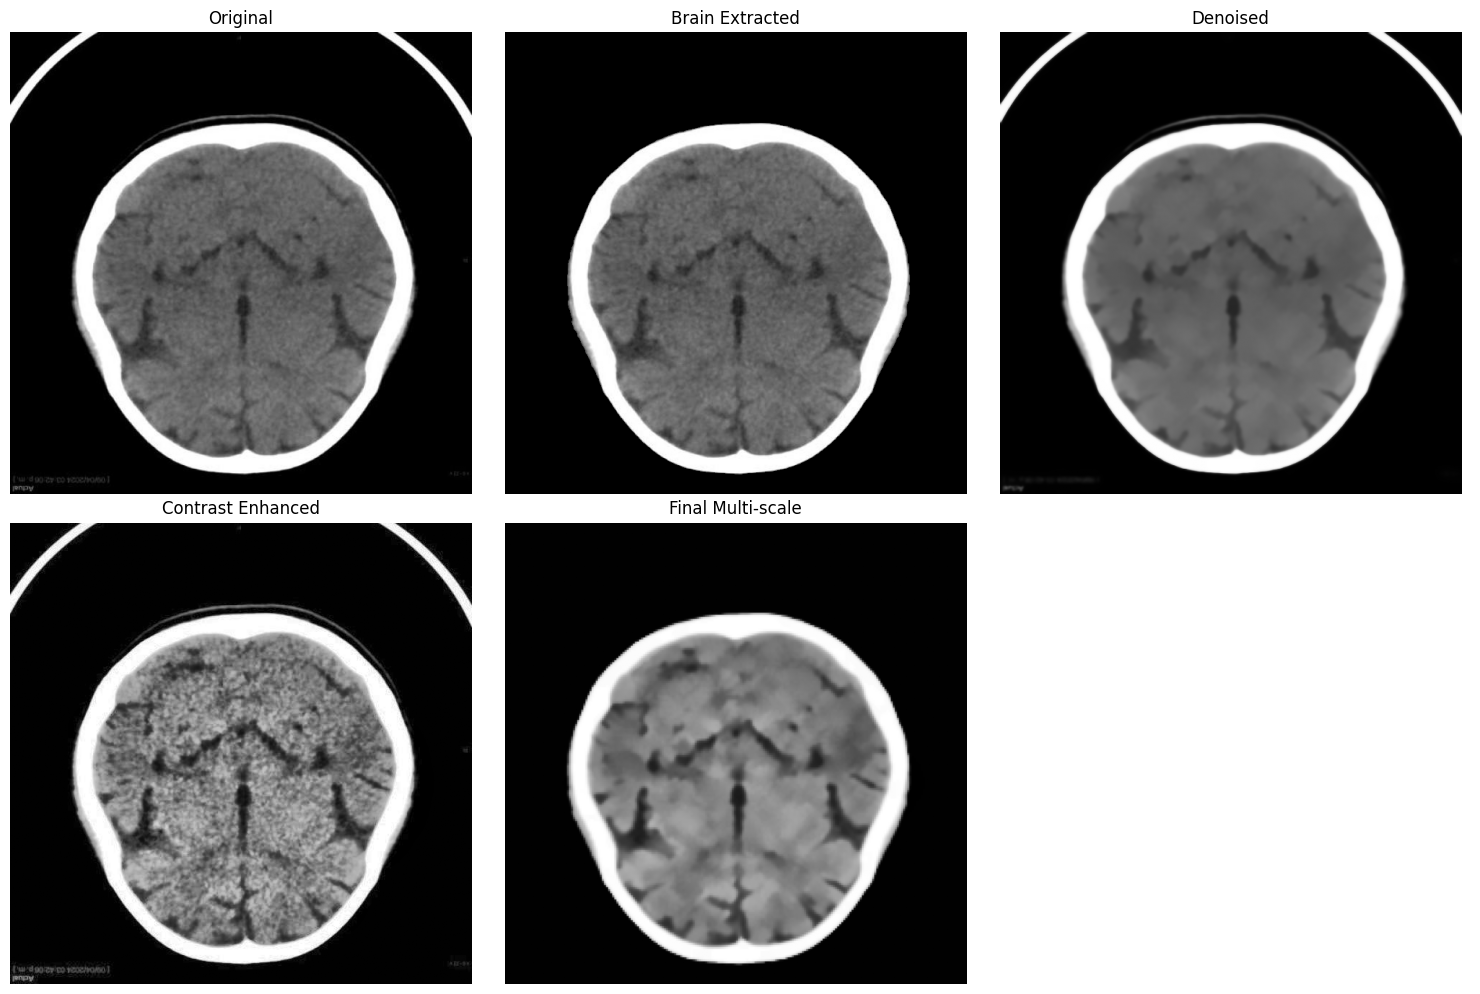

Visualizing sample 2: CT_tumor_1743.jpg


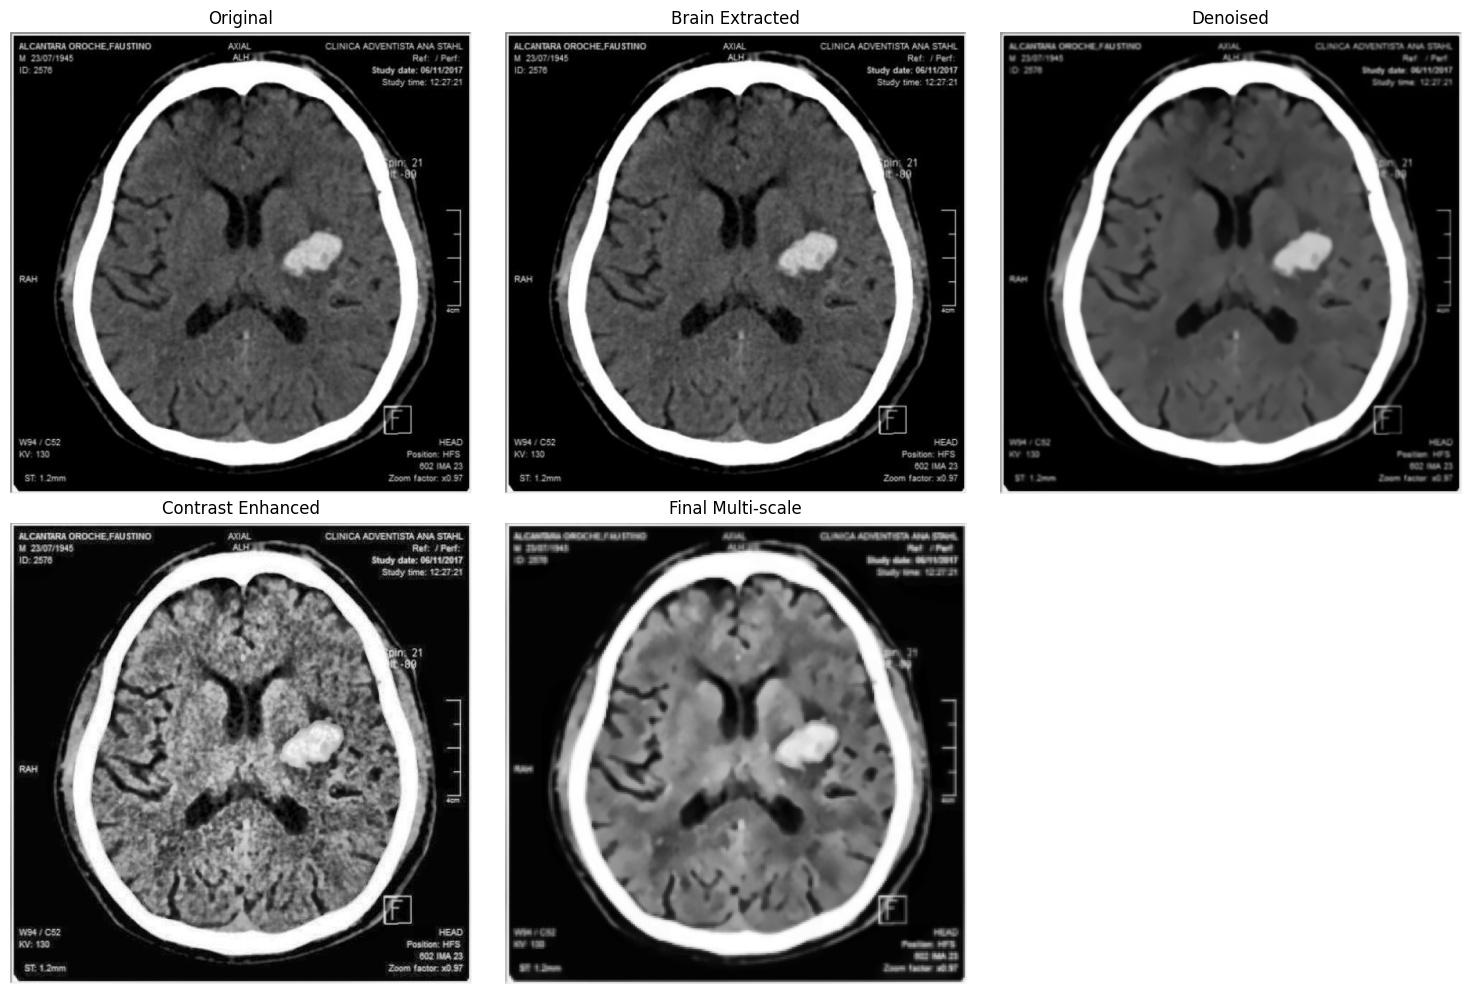

Visualizing sample 3: CT_tumor_0542.jpg


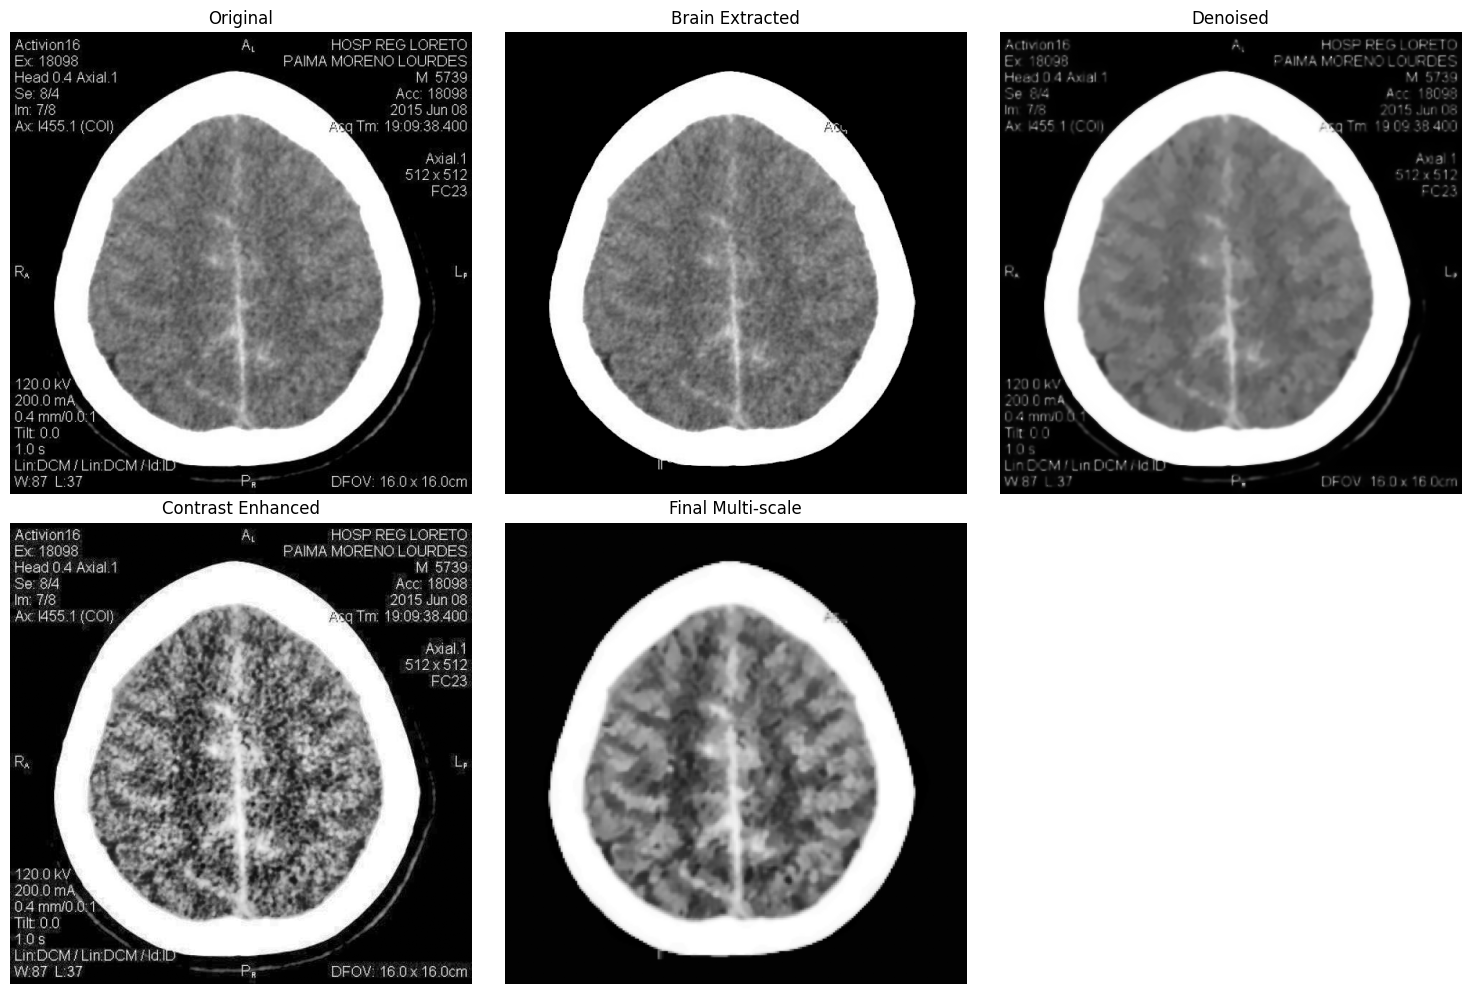


🎉 Enhanced preprocessing complete!
📁 Enhanced dataset saved in: /Users/jeissonparra/Library/CloudStorage/OneDrive-FloridaInternationalUniversity/Special_Topics_Advanced_Computational_Methods_in_Health_and_Biomedical_Data/Class_project_Early_detection_of_brain_tumor/CT_enhanced
📊 Quality metrics available in preprocessor.quality_metrics


In [2]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

class MedicalImagePreprocessor:
    """
    Comprehensive medical image preprocessing pipeline based on research papers
    """
    
    def __init__(self, target_size=(224, 224)):
        self.target_size = target_size
        self.quality_metrics = {}
        
    def load_image(self, image_path):
        """Load image with error handling"""
        if isinstance(image_path, str):
            image_path = Path(image_path)
        
        try:
            # Try multiple color modes
            image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
            if image is None:
                image = cv2.imread(str(image_path), cv2.IMREAD_COLOR)
                if image is not None:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            
            if image is None:
                print(f"Warning: Could not load image {image_path}")
                return None
                
            return image
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return None
    
    def calculate_psnr(self, original, processed):
        """Calculate PSNR without skimage"""
        if original.shape != processed.shape:
            processed = cv2.resize(processed, (original.shape[1], original.shape[0]))
            
        mse = np.mean((original.astype(float) - processed.astype(float)) ** 2)
        if mse == 0:
            return float('inf')
        return 20 * np.log10(255.0 / np.sqrt(mse))
    
    def calculate_ssim(self, original, processed):
        """Simplified SSIM calculation without skimage"""
        if original.shape != processed.shape:
            processed = cv2.resize(processed, (original.shape[1], original.shape[0]))
            
        # Convert to float
        original = original.astype(float)
        processed = processed.astype(float)
        
        # Constants for stability
        C1 = (0.01 * 255) ** 2
        C2 = (0.03 * 255) ** 2
        
        # Calculate means
        mu_x = np.mean(original)
        mu_y = np.mean(processed)
        
        # Calculate variances and covariance
        sigma_x = np.var(original)
        sigma_y = np.var(processed)
        sigma_xy = np.cov(original.flatten(), processed.flatten())[0, 1]
        
        # Calculate SSIM
        numerator = (2 * mu_x * mu_y + C1) * (2 * sigma_xy + C2)
        denominator = (mu_x ** 2 + mu_y ** 2 + C1) * (sigma_x + sigma_y + C2)
        
        return numerator / denominator
    
    def medical_denoise(self, image):
        """
        Medical-grade denoising based on research papers
        """
        if image.dtype != np.uint8:
            image = image.astype(np.uint8)
            
        # Method 1: Non-local means denoising (from denoising paper)
        denoised = cv2.fastNlMeansDenoising(
            image, 
            h=12,  # Filter strength
            templateWindowSize=7, 
            searchWindowSize=21
        )
        
        # Method 2: Median filtering for salt-and-pepper noise
        denoised = cv2.medianBlur(denoised, 3)
        
        # Method 3: Bilateral filtering for edge preservation
        denoised = cv2.bilateralFilter(denoised, 5, 75, 75)
        
        return denoised
    
    def advanced_contrast_enhancement(self, image):
        """
        Multi-stage contrast enhancement from hybrid learning paper
        """
        if image.dtype != np.uint8:
            image = image.astype(np.uint8)
            
        # CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(image)
        
        # Adaptive gamma correction
        mean_intensity = np.mean(enhanced)
        gamma = 1.0 - (mean_intensity - 127) / 255 * 0.4  # Adaptive gamma
        gamma = max(0.5, min(1.5, gamma))  # Clamp gamma values
        
        # Build lookup table for gamma correction
        inv_gamma = 1.0 / gamma
        table = np.array([((i / 255.0) ** inv_gamma) * 255 
                         for i in np.arange(0, 256)]).astype("uint8")
        enhanced = cv2.LUT(enhanced, table)
        
        return enhanced
    
    def extract_brain_region(self, image):
        """
        Simple brain region extraction using thresholding and morphology
        """
        # Otsu's thresholding
        _, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Morphological operations to clean up
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
        
        # Find largest contour (assumed to be brain)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            mask = np.zeros_like(image)
            cv2.drawContours(mask, [largest_contour], -1, 255, -1)
            
            # Apply mask
            result = cv2.bitwise_and(image, image, mask=mask)
            return result
        else:
            return image
    
    def multi_scale_processing(self, image):
        """
        Multi-scale feature preservation inspired by CLM paper
        """
        # Original resolution processing
        original = cv2.resize(image, self.target_size)
        
        # Downsampled processing for global context
        downsampled = cv2.resize(image, (self.target_size[0]//2, self.target_size[1]//2))
        downsampled = cv2.resize(downsampled, self.target_size)
        
        # Edge-enhanced processing
        edges = cv2.Canny(image, 30, 100)
        edges = cv2.resize(edges, self.target_size)
        
        # Texture-enhanced processing using gradient
        sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
        texture = np.sqrt(sobelx**2 + sobely**2)
        texture = cv2.normalize(texture, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        texture = cv2.resize(texture, self.target_size)
        
        # Stack all channels
        multi_scale = np.stack([original, downsampled, edges, texture], axis=-1)
        
        return multi_scale
    
    def calculate_quality_metrics(self, original, processed, image_name):
        """
        Calculate PSNR and SSIM metrics as done in research papers
        """
        if original.shape != processed.shape:
            processed_resized = cv2.resize(processed, (original.shape[1], original.shape[0]))
        else:
            processed_resized = processed
            
        # Ensure same data type
        if original.dtype != processed_resized.dtype:
            processed_resized = processed_resized.astype(original.dtype)
            
        # Calculate metrics using custom functions
        psnr = self.calculate_psnr(original, processed_resized)
        ssim = self.calculate_ssim(original, processed_resized)
        
        self.quality_metrics[image_name] = {
            'psnr': psnr,
            'ssim': ssim
        }
        
        return psnr, ssim
    
    def comprehensive_preprocessing(self, image_path, save_quality_metrics=True):
        """
        Complete preprocessing pipeline incorporating research findings
        """
        # Load image
        original_image = self.load_image(image_path)
        if original_image is None:
            return None
        
        # Store original for quality metrics
        original_copy = original_image.copy()
        
        # Step 1: Brain region extraction (if applicable)
        brain_extracted = self.extract_brain_region(original_image)
        
        # Step 2: Medical-grade denoising
        denoised = self.medical_denoise(brain_extracted)
        
        # Step 3: Advanced contrast enhancement
        enhanced = self.advanced_contrast_enhancement(denoised)
        
        # Step 4: Multi-scale processing
        processed = self.multi_scale_processing(enhanced)
        
        # Step 5: Normalization
        processed = processed.astype(np.float32) / 255.0
        
        # Calculate quality metrics
        if save_quality_metrics:
            image_name = Path(image_path).name
            psnr, ssim = self.calculate_quality_metrics(original_copy, 
                                                       (processed[:,:,0] * 255).astype(np.uint8), 
                                                       image_name)
        
        return processed
    
    def research_augmentation(self, image):
        """
        Research-backed data augmentation techniques
        """
        augmentations = []
        
        if len(image.shape) == 3:
            image = image[:,:,0]  # Use first channel for augmentation
        
        # Convert to uint8 for OpenCV operations
        if image.dtype != np.uint8:
            image_uint8 = (image * 255).astype(np.uint8)
        else:
            image_uint8 = image
        
        # 1. Gaussian noise addition (from denoising paper)
        for sigma in [10, 15, 20]:
            noise = np.random.normal(0, sigma, image_uint8.shape).astype(np.float32)
            noisy_image = image_uint8.astype(np.float32) + noise
            noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
            augmentations.append(noisy_image)
        
        # 2. Rotation with smaller angles for medical images
        height, width = image_uint8.shape
        for angle in [-10, -5, 5, 10]:
            matrix = cv2.getRotationMatrix2D((width/2, height/2), angle, 1.0)
            rotated = cv2.warpAffine(image_uint8, matrix, (width, height))
            augmentations.append(rotated)
        
        # 3. Contrast variations (from hybrid learning paper)
        for contrast_factor in [0.7, 0.9, 1.1, 1.3]:
            contrasted = np.clip(image_uint8.astype(np.float32) * contrast_factor, 0, 255)
            augmentations.append(contrasted.astype(np.uint8))
        
        # 4. Brightness variations
        for brightness in [-20, -10, 10, 20]:
            brightened = np.clip(image_uint8.astype(np.float32) + brightness, 0, 255)
            augmentations.append(brightened.astype(np.uint8))
        
        # 5. Flip augmentations
        augmentations.append(cv2.flip(image_uint8, 0))  # Vertical flip
        augmentations.append(cv2.flip(image_uint8, 1))  # Horizontal flip
        
        return augmentations
    
    def visualize_preprocessing_steps(self, image_path, save_path=None):
        """
        Visualize each step of the preprocessing pipeline
        """
        original = self.load_image(image_path)
        if original is None:
            return
        
        steps = {
            'Original': original,
            'Brain Extracted': self.extract_brain_region(original),
            'Denoised': self.medical_denoise(original),
            'Contrast Enhanced': self.advanced_contrast_enhancement(original),
        }
        
        # Apply full pipeline for final result
        final = self.comprehensive_preprocessing(image_path, save_quality_metrics=False)
        if final is not None:
            steps['Final Multi-scale'] = (final[:,:,0] * 255).astype(np.uint8)
        
        # Create visualization
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.ravel()
        
        for idx, (step_name, step_image) in enumerate(steps.items()):
            if idx < len(axes):
                axes[idx].imshow(step_image, cmap='gray')
                axes[idx].set_title(step_name)
                axes[idx].axis('off')
        
        # Hide empty subplots
        for idx in range(len(steps), len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def print_quality_report(self):
        """Print quality metrics report"""
        if not self.quality_metrics:
            print("No quality metrics available. Run preprocessing first.")
            return
        
        psnrs = [metrics['psnr'] for metrics in self.quality_metrics.values()]
        ssims = [metrics['ssim'] for metrics in self.quality_metrics.values()]
        
        print("\n=== PREPROCESSING QUALITY REPORT ===")
        print(f"Processed Images: {len(self.quality_metrics)}")
        print(f"Average PSNR: {np.mean(psnrs):.2f} dB")
        print(f"Average SSIM: {np.mean(ssims):.4f}")
        print(f"Best PSNR: {np.max(psnrs):.2f} dB")
        print(f"Worst PSNR: {np.min(psnrs):.2f} dB")
        print("====================================\n")

def detect_label(path):
    """Label based on folder name"""
    path_str = str(path).lower()
    
    if "/normal/" in path_str:
        return "normal"
    if "/tumor/" in path_str:
        return "tumor"
    
    return None

def main():
    # Configuration
    RAW_DATASET = "/Users/jeissonparra/Library/CloudStorage/OneDrive-FloridaInternationalUniversity/Special_Topics_Advanced_Computational_Methods_in_Health_and_Biomedical_Data/Class_project_Early_detection_of_brain_tumor/CT"
    OUTPUT_DATASET = "/Users/jeissonparra/Library/CloudStorage/OneDrive-FloridaInternationalUniversity/Special_Topics_Advanced_Computational_Methods_in_Health_and_Biomedical_Data/Class_project_Early_detection_of_brain_tumor/CT_enhanced"
    
    # Initialize preprocessor
    preprocessor = MedicalImagePreprocessor(target_size=(224, 224))
    
    # Create output directories
    for split in ["train", "val", "test"]:
        for label in ["tumor", "normal"]:
            os.makedirs(f"{OUTPUT_DATASET}/{split}/{label}", exist_ok=True)
    
    # Supported extensions
    valid_ext = [".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"]
    
    # Collect all images
    print("🔍 Scanning for images...")
    all_images = [
        p for p in Path(RAW_DATASET).rglob("*")
        if p.is_file() and p.suffix.lower() in valid_ext
    ]
    
    print(f"📁 Found {len(all_images)} total image files")
    
    # Filter and label images
    clean_data = []
    for img_path in all_images:
        label = detect_label(img_path)
        if label:
            clean_data.append((img_path, label))
    
    print(f"✅ Usable images: {len(clean_data)}")
    print(f"🦠 Tumor: {sum(1 for _,l in clean_data if l=='tumor')}")
    print(f"❤️ Normal: {sum(1 for _,l in clean_data if l=='normal')}")
    
    if len(clean_data) == 0:
        print("❌ No images found! Check your RAW_DATASET path and folder structure.")
        return
    
    # Shuffle and split
    random.shuffle(clean_data)
    train_split = int(0.7 * len(clean_data))
    val_split = int(0.85 * len(clean_data))
    
    splits = {
        "train": clean_data[:train_split],
        "val": clean_data[train_split:val_split],
        "test": clean_data[val_split:]
    }
    
    # Process & Save with enhanced preprocessing
    print("\n🚀 Starting enhanced preprocessing...")
    
    for split_name, split_data in splits.items():
        print(f"\n📂 Processing {split_name} set ({len(split_data)} images)...")
        
        for img_path, label in tqdm(split_data, desc=f"Processing {split_name}"):
            try:
                # Apply comprehensive preprocessing
                processed = preprocessor.comprehensive_preprocessing(img_path)
                
                if processed is not None:
                    # Save as numpy array to preserve multi-channel data
                    filename = f"{img_path.stem}_processed.npy"
                    output_path = f"{OUTPUT_DATASET}/{split_name}/{label}/{filename}"
                    
                    # Save both numpy array and image for compatibility
                    np.save(output_path, processed)
                    
                    # Also save as image (first channel)
                    image_output_path = output_path.replace('.npy', '.png')
                    cv2.imwrite(image_output_path, (processed[:,:,0] * 255).astype(np.uint8))
                    
            except Exception as e:
                print(f"❌ Error processing {img_path}: {e}")
                continue
    
    # Generate quality report
    preprocessor.print_quality_report()
    
    # Visualize preprocessing steps for a few samples
    print("\n📊 Generating preprocessing visualization...")
    sample_images = [img_path for img_path, _ in clean_data[:3]]
    for i, sample_path in enumerate(sample_images):
        print(f"Visualizing sample {i+1}: {sample_path.name}")
        preprocessor.visualize_preprocessing_steps(
            sample_path, 
            save_path=f"preprocessing_steps_sample_{i+1}.png"
        )
    
    print(f"\n🎉 Enhanced preprocessing complete!")
    print(f"📁 Enhanced dataset saved in: {OUTPUT_DATASET}")
    print(f"📊 Quality metrics available in preprocessor.quality_metrics")

if __name__ == "__main__":
    main()

In [3]:
!git clone https://github.com/JeissonParra12/Class_project_Early_detection_of_brain_tumor.git

fatal: destination path 'Class_project_Early_detection_of_brain_tumor' already exists and is not an empty directory.


🔍 Scanning for images...
📁 Found 4618 total image files
✅ Usable images: 4618
🦠 Tumor: 2318
❤️ Normal: 2300

🚀 Starting enhanced preprocessing...

📂 Processing train set (3232 images)...


Processing train: 100%|██████████| 3232/3232 [10:13<00:00,  5.27it/s]



📂 Processing val set (693 images)...


Processing val: 100%|██████████| 693/693 [02:10<00:00,  5.32it/s]



📂 Processing test set (693 images)...


Processing test: 100%|██████████| 693/693 [02:08<00:00,  5.37it/s]



=== PREPROCESSING QUALITY REPORT ===
Processed Images: 4618
Average PSNR: 19.64 dB
Average SSIM: 0.9291
Best PSNR: 31.50 dB
Worst PSNR: 6.77 dB


📊 Generating preprocessing visualization...
Visualizing sample 1: CT_normal_1869.png


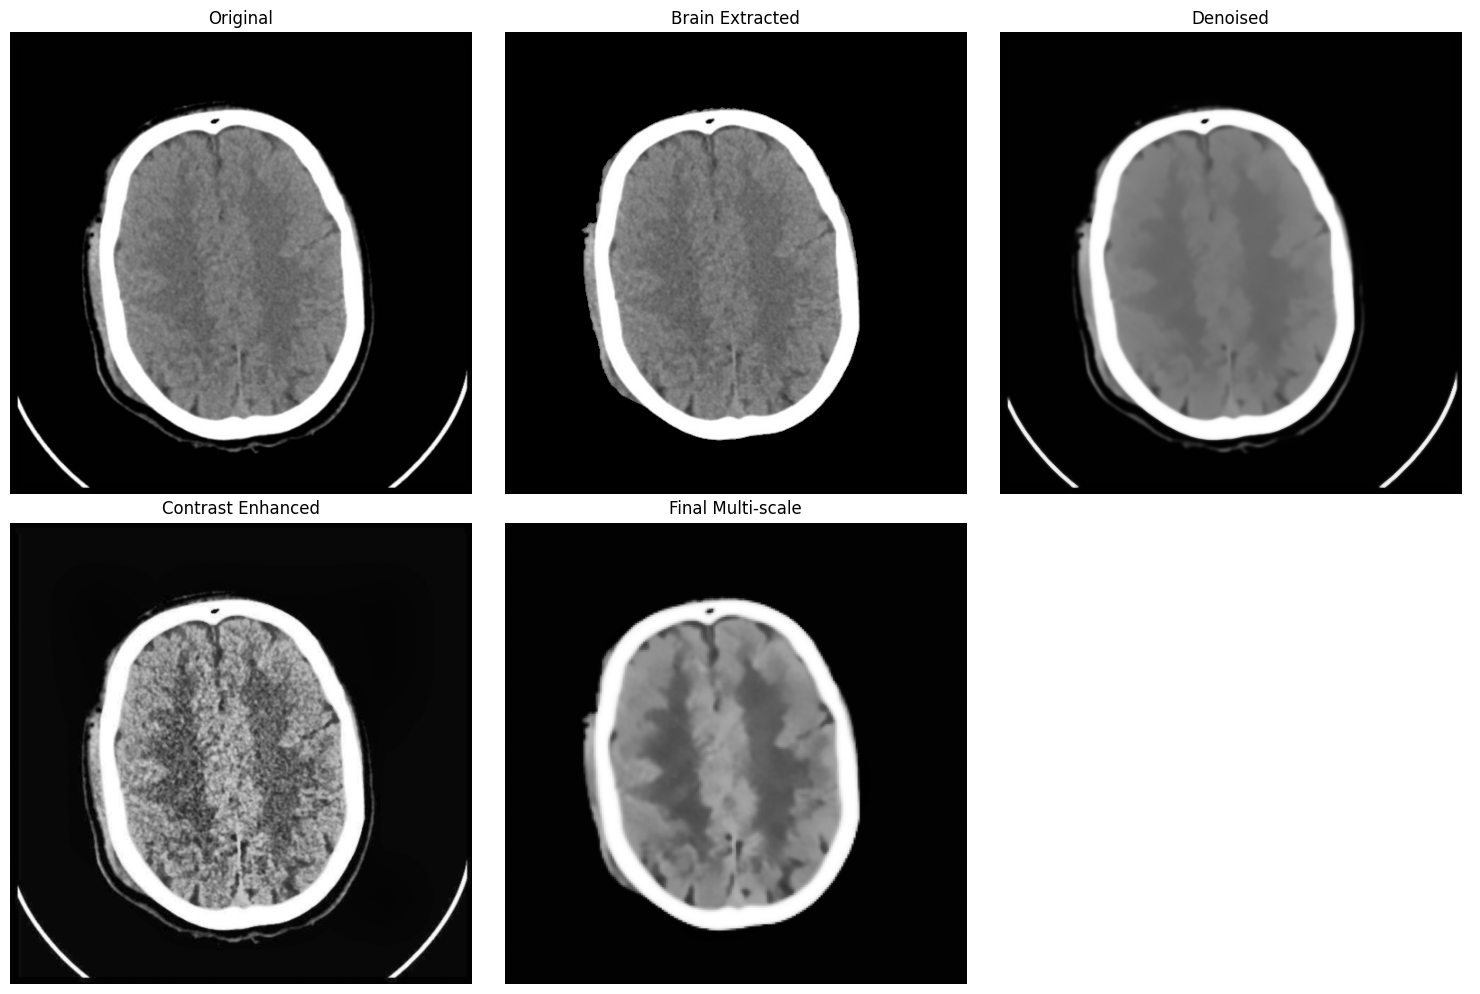

Visualizing sample 2: CT_normal_1549.png


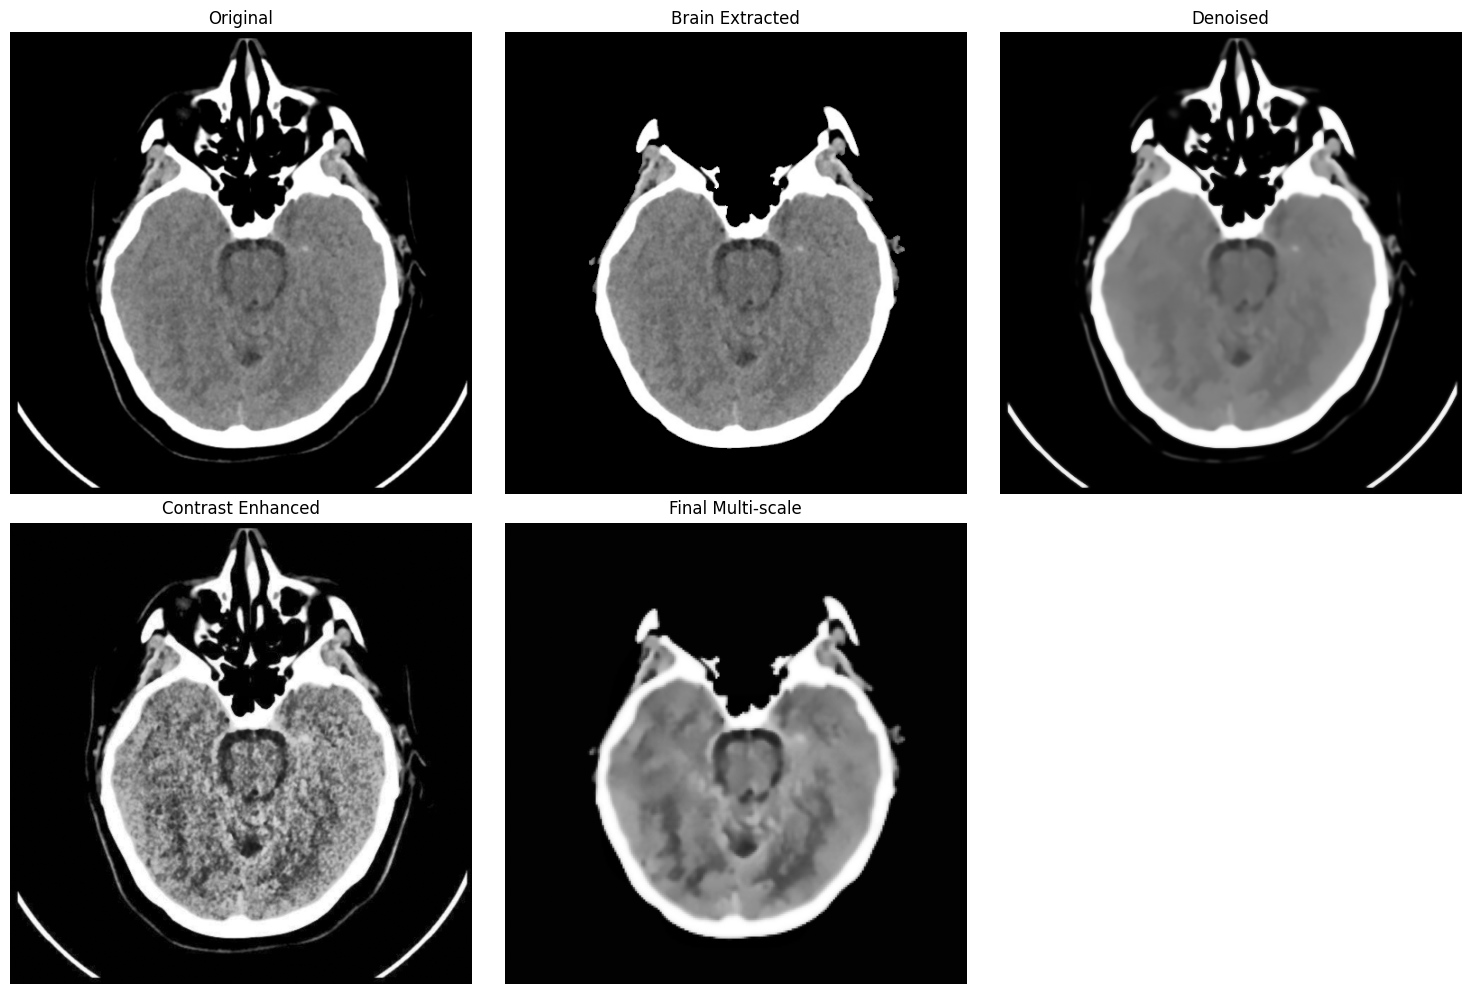

Visualizing sample 3: CT_normal_0246.jpg


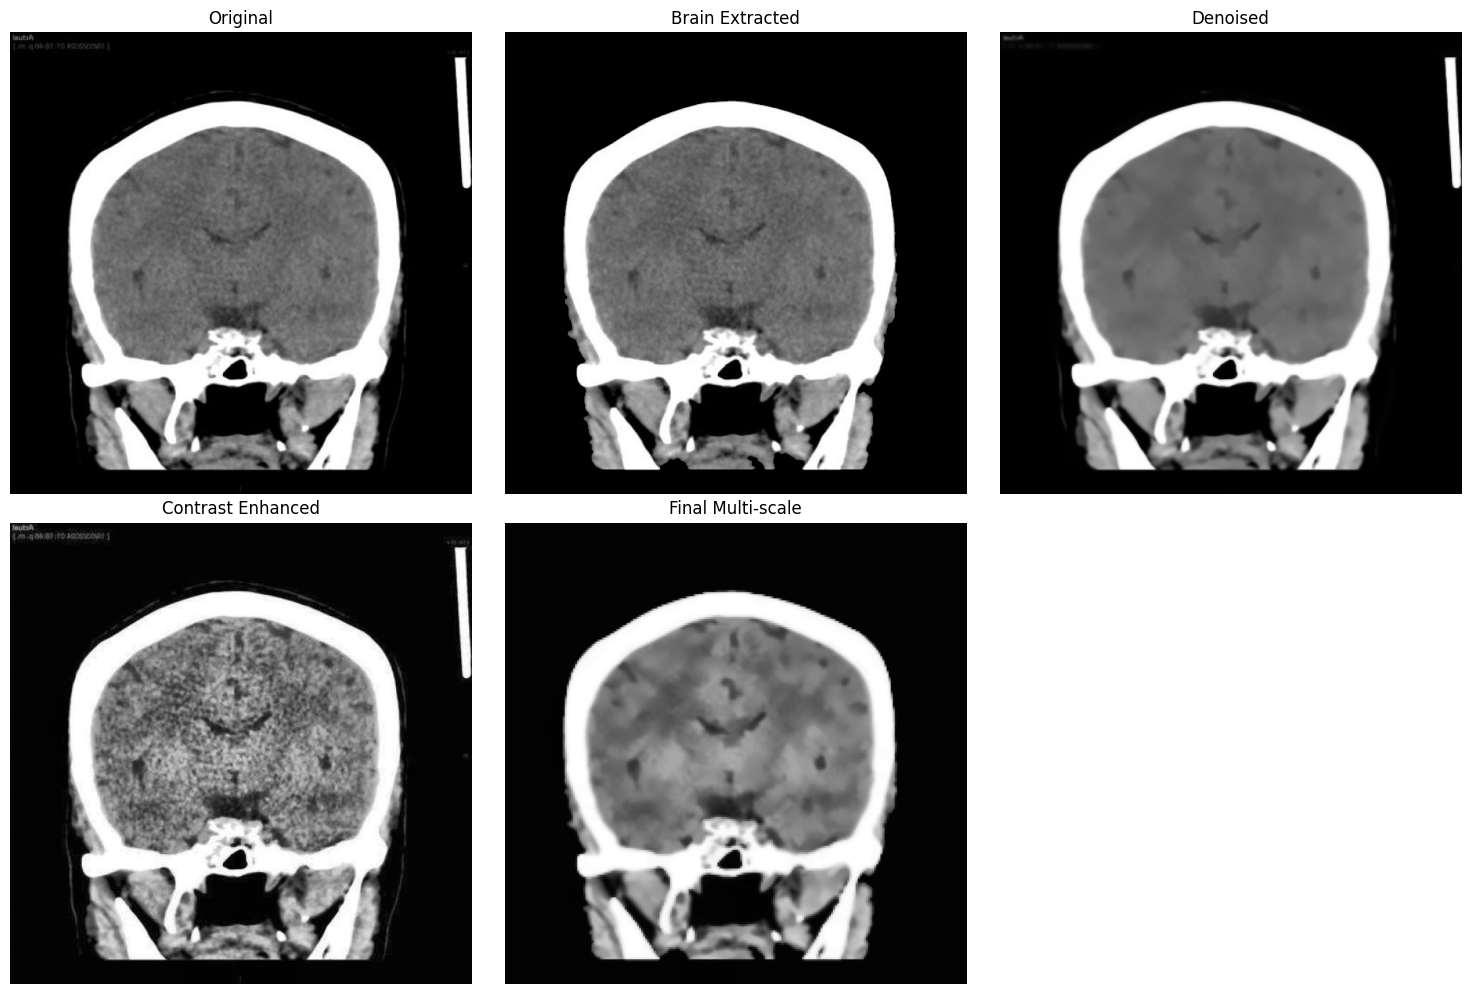


🎉 Enhanced preprocessing complete!
📁 Enhanced dataset saved in: /Users/jeissonparra/Library/CloudStorage/OneDrive-FloridaInternationalUniversity/Special_Topics_Advanced_Computational_Methods_in_Health_and_Biomedical_Data/Class_project_Early_detection_of_brain_tumor/CT_enhanced
📊 Quality metrics available in preprocessor.quality_metrics


In [4]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

class MedicalImagePreprocessor:
    """
    Comprehensive medical image preprocessing pipeline based on research papers
    """
    
    def __init__(self, target_size=(224, 224)):
        self.target_size = target_size
        self.quality_metrics = {}
        
    def load_image(self, image_path):
        """Load image with error handling"""
        if isinstance(image_path, str):
            image_path = Path(image_path)
        
        try:
            # Try multiple color modes
            image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
            if image is None:
                image = cv2.imread(str(image_path), cv2.IMREAD_COLOR)
                if image is not None:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            
            if image is None:
                print(f"Warning: Could not load image {image_path}")
                return None
                
            return image
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return None
    
    def calculate_psnr(self, original, processed):
        """Calculate PSNR without skimage"""
        if original.shape != processed.shape:
            processed = cv2.resize(processed, (original.shape[1], original.shape[0]))
            
        mse = np.mean((original.astype(float) - processed.astype(float)) ** 2)
        if mse == 0:
            return float('inf')
        return 20 * np.log10(255.0 / np.sqrt(mse))
    
    def calculate_ssim(self, original, processed):
        """Simplified SSIM calculation without skimage"""
        if original.shape != processed.shape:
            processed = cv2.resize(processed, (original.shape[1], original.shape[0]))
            
        # Convert to float
        original = original.astype(float)
        processed = processed.astype(float)
        
        # Constants for stability
        C1 = (0.01 * 255) ** 2
        C2 = (0.03 * 255) ** 2
        
        # Calculate means
        mu_x = np.mean(original)
        mu_y = np.mean(processed)
        
        # Calculate variances and covariance
        sigma_x = np.var(original)
        sigma_y = np.var(processed)
        sigma_xy = np.cov(original.flatten(), processed.flatten())[0, 1]
        
        # Calculate SSIM
        numerator = (2 * mu_x * mu_y + C1) * (2 * sigma_xy + C2)
        denominator = (mu_x ** 2 + mu_y ** 2 + C1) * (sigma_x + sigma_y + C2)
        
        return numerator / denominator
    
    def medical_denoise(self, image):
        """
        Medical-grade denoising based on research papers
        """
        if image.dtype != np.uint8:
            image = image.astype(np.uint8)
            
        # Method 1: Non-local means denoising (from denoising paper)
        denoised = cv2.fastNlMeansDenoising(
            image, 
            h=12,  # Filter strength
            templateWindowSize=7, 
            searchWindowSize=21
        )
        
        # Method 2: Median filtering for salt-and-pepper noise
        denoised = cv2.medianBlur(denoised, 3)
        
        # Method 3: Bilateral filtering for edge preservation
        denoised = cv2.bilateralFilter(denoised, 5, 75, 75)
        
        return denoised
    
    def advanced_contrast_enhancement(self, image):
        """
        Multi-stage contrast enhancement from hybrid learning paper
        """
        if image.dtype != np.uint8:
            image = image.astype(np.uint8)
            
        # CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(image)
        
        # Adaptive gamma correction
        mean_intensity = np.mean(enhanced)
        gamma = 1.0 - (mean_intensity - 127) / 255 * 0.4  # Adaptive gamma
        gamma = max(0.5, min(1.5, gamma))  # Clamp gamma values
        
        # Build lookup table for gamma correction
        inv_gamma = 1.0 / gamma
        table = np.array([((i / 255.0) ** inv_gamma) * 255 
                         for i in np.arange(0, 256)]).astype("uint8")
        enhanced = cv2.LUT(enhanced, table)
        
        return enhanced
    
    def extract_brain_region(self, image):
        """
        Simple brain region extraction using thresholding and morphology
        """
        # Otsu's thresholding
        _, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Morphological operations to clean up
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
        
        # Find largest contour (assumed to be brain)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            mask = np.zeros_like(image)
            cv2.drawContours(mask, [largest_contour], -1, 255, -1)
            
            # Apply mask
            result = cv2.bitwise_and(image, image, mask=mask)
            return result
        else:
            return image
    
    def multi_scale_processing(self, image):
        """
        Multi-scale feature preservation inspired by CLM paper
        """
        # Original resolution processing
        original = cv2.resize(image, self.target_size)
        
        # Downsampled processing for global context
        downsampled = cv2.resize(image, (self.target_size[0]//2, self.target_size[1]//2))
        downsampled = cv2.resize(downsampled, self.target_size)
        
        # Edge-enhanced processing
        edges = cv2.Canny(image, 30, 100)
        edges = cv2.resize(edges, self.target_size)
        
        # Texture-enhanced processing using gradient
        sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
        texture = np.sqrt(sobelx**2 + sobely**2)
        texture = cv2.normalize(texture, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        texture = cv2.resize(texture, self.target_size)
        
        # Stack all channels
        multi_scale = np.stack([original, downsampled, edges, texture], axis=-1)
        
        return multi_scale
    
    def calculate_quality_metrics(self, original, processed, image_name):
        """
        Calculate PSNR and SSIM metrics as done in research papers
        """
        if original.shape != processed.shape:
            processed_resized = cv2.resize(processed, (original.shape[1], original.shape[0]))
        else:
            processed_resized = processed
            
        # Ensure same data type
        if original.dtype != processed_resized.dtype:
            processed_resized = processed_resized.astype(original.dtype)
            
        # Calculate metrics using custom functions
        psnr = self.calculate_psnr(original, processed_resized)
        ssim = self.calculate_ssim(original, processed_resized)
        
        self.quality_metrics[image_name] = {
            'psnr': psnr,
            'ssim': ssim
        }
        
        return psnr, ssim
    
    def comprehensive_preprocessing(self, image_path, save_quality_metrics=True):
        """
        Complete preprocessing pipeline incorporating research findings
        """
        # Load image
        original_image = self.load_image(image_path)
        if original_image is None:
            return None
        
        # Store original for quality metrics
        original_copy = original_image.copy()
        
        # Step 1: Brain region extraction (if applicable)
        brain_extracted = self.extract_brain_region(original_image)
        
        # Step 2: Medical-grade denoising
        denoised = self.medical_denoise(brain_extracted)
        
        # Step 3: Advanced contrast enhancement
        enhanced = self.advanced_contrast_enhancement(denoised)
        
        # Step 4: Multi-scale processing
        processed = self.multi_scale_processing(enhanced)
        
        # Step 5: Normalization
        processed = processed.astype(np.float32) / 255.0
        
        # Calculate quality metrics
        if save_quality_metrics:
            image_name = Path(image_path).name
            psnr, ssim = self.calculate_quality_metrics(original_copy, 
                                                       (processed[:,:,0] * 255).astype(np.uint8), 
                                                       image_name)
        
        return processed
    
    def research_augmentation(self, image):
        """
        Research-backed data augmentation techniques
        """
        augmentations = []
        
        if len(image.shape) == 3:
            image = image[:,:,0]  # Use first channel for augmentation
        
        # Convert to uint8 for OpenCV operations
        if image.dtype != np.uint8:
            image_uint8 = (image * 255).astype(np.uint8)
        else:
            image_uint8 = image
        
        # 1. Gaussian noise addition (from denoising paper)
        for sigma in [10, 15, 20]:
            noise = np.random.normal(0, sigma, image_uint8.shape).astype(np.float32)
            noisy_image = image_uint8.astype(np.float32) + noise
            noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
            augmentations.append(noisy_image)
        
        # 2. Rotation with smaller angles for medical images
        height, width = image_uint8.shape
        for angle in [-10, -5, 5, 10]:
            matrix = cv2.getRotationMatrix2D((width/2, height/2), angle, 1.0)
            rotated = cv2.warpAffine(image_uint8, matrix, (width, height))
            augmentations.append(rotated)
        
        # 3. Contrast variations (from hybrid learning paper)
        for contrast_factor in [0.7, 0.9, 1.1, 1.3]:
            contrasted = np.clip(image_uint8.astype(np.float32) * contrast_factor, 0, 255)
            augmentations.append(contrasted.astype(np.uint8))
        
        # 4. Brightness variations
        for brightness in [-20, -10, 10, 20]:
            brightened = np.clip(image_uint8.astype(np.float32) + brightness, 0, 255)
            augmentations.append(brightened.astype(np.uint8))
        
        # 5. Flip augmentations
        augmentations.append(cv2.flip(image_uint8, 0))  # Vertical flip
        augmentations.append(cv2.flip(image_uint8, 1))  # Horizontal flip
        
        return augmentations
    
    def visualize_preprocessing_steps(self, image_path, save_path=None):
        """
        Visualize each step of the preprocessing pipeline
        """
        original = self.load_image(image_path)
        if original is None:
            return
        
        steps = {
            'Original': original,
            'Brain Extracted': self.extract_brain_region(original),
            'Denoised': self.medical_denoise(original),
            'Contrast Enhanced': self.advanced_contrast_enhancement(original),
        }
        
        # Apply full pipeline for final result
        final = self.comprehensive_preprocessing(image_path, save_quality_metrics=False)
        if final is not None:
            steps['Final Multi-scale'] = (final[:,:,0] * 255).astype(np.uint8)
        
        # Create visualization
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.ravel()
        
        for idx, (step_name, step_image) in enumerate(steps.items()):
            if idx < len(axes):
                axes[idx].imshow(step_image, cmap='gray')
                axes[idx].set_title(step_name)
                axes[idx].axis('off')
        
        # Hide empty subplots
        for idx in range(len(steps), len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def print_quality_report(self):
        """Print quality metrics report"""
        if not self.quality_metrics:
            print("No quality metrics available. Run preprocessing first.")
            return
        
        psnrs = [metrics['psnr'] for metrics in self.quality_metrics.values()]
        ssims = [metrics['ssim'] for metrics in self.quality_metrics.values()]
        
        print("\n=== PREPROCESSING QUALITY REPORT ===")
        print(f"Processed Images: {len(self.quality_metrics)}")
        print(f"Average PSNR: {np.mean(psnrs):.2f} dB")
        print(f"Average SSIM: {np.mean(ssims):.4f}")
        print(f"Best PSNR: {np.max(psnrs):.2f} dB")
        print(f"Worst PSNR: {np.min(psnrs):.2f} dB")
        print("====================================\n")

def detect_label(path):
    """Label based on folder name"""
    path_str = str(path).lower()
    
    if "/normal/" in path_str:
        return "normal"
    if "/tumor/" in path_str:
        return "tumor"
    
    return None

def main():
    # Configuration
    RAW_DATASET = "/content/Class_project_Early_detection_of_brain_tumor/CT"
    OUTPUT_DATASET = "/Users/jeissonparra/Library/CloudStorage/OneDrive-FloridaInternationalUniversity/Special_Topics_Advanced_Computational_Methods_in_Health_and_Biomedical_Data/Class_project_Early_detection_of_brain_tumor/CT_enhanced"
    
    # Initialize preprocessor
    preprocessor = MedicalImagePreprocessor(target_size=(224, 224))
    
    # Create output directories
    for split in ["train", "val", "test"]:
        for label in ["tumor", "normal"]:
            os.makedirs(f"{OUTPUT_DATASET}/{split}/{label}", exist_ok=True)
    
    # Supported extensions
    valid_ext = [".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"]
    
    # Collect all images
    print("🔍 Scanning for images...")
    all_images = [
        p for p in Path(RAW_DATASET).rglob("*")
        if p.is_file() and p.suffix.lower() in valid_ext
    ]
    
    print(f"📁 Found {len(all_images)} total image files")
    
    # Filter and label images
    clean_data = []
    for img_path in all_images:
        label = detect_label(img_path)
        if label:
            clean_data.append((img_path, label))
    
    print(f"✅ Usable images: {len(clean_data)}")
    print(f"🦠 Tumor: {sum(1 for _,l in clean_data if l=='tumor')}")
    print(f"❤️ Normal: {sum(1 for _,l in clean_data if l=='normal')}")
    
    if len(clean_data) == 0:
        print("❌ No images found! Check your RAW_DATASET path and folder structure.")
        return
    
    # Shuffle and split
    random.shuffle(clean_data)
    train_split = int(0.7 * len(clean_data))
    val_split = int(0.85 * len(clean_data))
    
    splits = {
        "train": clean_data[:train_split],
        "val": clean_data[train_split:val_split],
        "test": clean_data[val_split:]
    }
    
    # Process & Save with enhanced preprocessing
    print("\n🚀 Starting enhanced preprocessing...")
    
    for split_name, split_data in splits.items():
        print(f"\n📂 Processing {split_name} set ({len(split_data)} images)...")
        
        for img_path, label in tqdm(split_data, desc=f"Processing {split_name}"):
            try:
                # Apply comprehensive preprocessing
                processed = preprocessor.comprehensive_preprocessing(img_path)
                
                if processed is not None:
                    # Save as numpy array to preserve multi-channel data
                    filename = f"{img_path.stem}_processed.npy"
                    output_path = f"{OUTPUT_DATASET}/{split_name}/{label}/{filename}"
                    
                    # Save both numpy array and image for compatibility
                    np.save(output_path, processed)
                    
                    # Also save as image (first channel)
                    image_output_path = output_path.replace('.npy', '.png')
                    cv2.imwrite(image_output_path, (processed[:,:,0] * 255).astype(np.uint8))
                    
            except Exception as e:
                print(f"❌ Error processing {img_path}: {e}")
                continue
    
    # Generate quality report
    preprocessor.print_quality_report()
    
    # Visualize preprocessing steps for a few samples
    print("\n📊 Generating preprocessing visualization...")
    sample_images = [img_path for img_path, _ in clean_data[:3]]
    for i, sample_path in enumerate(sample_images):
        print(f"Visualizing sample {i+1}: {sample_path.name}")
        preprocessor.visualize_preprocessing_steps(
            sample_path, 
            save_path=f"preprocessing_steps_sample_{i+1}.png"
        )
    
    print(f"\n🎉 Enhanced preprocessing complete!")
    print(f"📁 Enhanced dataset saved in: {OUTPUT_DATASET}")
    print(f"📊 Quality metrics available in preprocessor.quality_metrics")

if __name__ == "__main__":
    main()